# Extended Wigner's friend scenario

In [1]:
import itertools
import functools
import random
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from mitiq import zne

import qiskit
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.providers import Backend
from qiskit.providers import fake_provider
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

## Observer and setting enums

In [2]:
class Setting(Enum):
    PEEK = 1
    REVERSE_1 = 2
    REVERSE_2 = 3
    
class Observer(Enum):
    ALICE = 0
    BOB = 1

## EWFS circuit

In [3]:
def prepare_bipartite_system(qc: QuantumCircuit):
    """Generates the state: 1/sqrt(2) * (|01> - |10>)"""
    qc.x(ALICE)
    qc.x(BOB)
    qc.h(ALICE)
    qc.cx(ALICE, BOB)


def cnot_ladder(qc: QuantumCircuit, observer: Observer, friend_qubit: int, friend_size: int):
    """CNOT ladder circuit (GHZ without Hadamard)."""
    for i in range(friend_size):
        qc.cx(observer, friend_qubit + i)


def ewfs_rotation(qc: QuantumCircuit, qubit: int, angle: float):
    qc.rz(-angle, qubit)
    qc.h(qubit)
    

def apply_setting(
    qc: QuantumCircuit,
    observer: Observer,
    setting: Setting,
    angle: float,
    charlie_size: int,
    debbie_size: int
):
    """Apply either the PEEK or REVERSE_1/REVERSE_2 settings."""
    alice_size, bob_size = 1, 1
    sys_size = alice_size + bob_size

    charlie_qubits = range(sys_size, (sys_size + charlie_size))
    debbie_qubits = range(sys_size + charlie_size, sys_size + (charlie_size + debbie_size))

    # Alice is the friend of Charlie and Bob is the friend of Debbie.
    friend_qubits = charlie_qubits if observer is ALICE else debbie_qubits
    friend_size = charlie_size if observer is ALICE else debbie_size
    
    if setting is PEEK:
        # Ask friend for the outcome. We pick a random qubit from friend's register.
        random_offset = random.randint(0, friend_size - 1)
        qc.measure(friend_qubits[0] + random_offset, observer)

    elif setting in [REVERSE_1, REVERSE_2]:
        cnot_ladder(qc, observer, friend_qubits[0], friend_size)

        # For either REVERSE_1 or REVERSE_2, apply the appropriate angle rotations.
        # Note that in this case, the rotation should occur on the observer's qubit.
        if observer is ALICE:
            qc.h(0)
            qc.rz(ANGLES[1], 0)        

        if observer is BOB:
            qc.h(1)        
            qc.rz((BETA - ANGLES[1]), 1)
        ewfs_rotation(qc, observer, angle)            
        qc.measure(observer, observer)
        

def ewfs(
    alice_setting: Setting,
    bob_setting: Setting,
    angles: list[float],
    beta: float,
    charlie_size: int,
    debbie_size: int,
) -> QuantumCircuit:
    """Generate the circuit for extended Wigner's friend scenario."""
    alice_size, bob_size = 1, 1
    sys_size = alice_size + bob_size
    
    # Define quantum registers
    alice, bob, charlie, debbie = [
        QuantumRegister(size, name=name) 
        for size, name in zip([alice_size, bob_size, charlie_size, debbie_size], 
                              ["Alice", "Bob", "Charlie", "Debbie"])
    ]
    measurement = ClassicalRegister(sys_size, name="Measurement")
    
    # Create the Quantum Circuit with the defined registers
    qc = QuantumCircuit(alice, bob, charlie, debbie, measurement)
    
    # Prepare the bipartite quantum system
    prepare_bipartite_system(qc)
    qc.rz(-angles[1], 0)
    qc.h(0)
    
    qc.rz(-(beta - angles[1]), 1)
    qc.h(1)

    charlie_qubits = range(sys_size, (sys_size + charlie_size))
    debbie_qubits = range(sys_size + charlie_size, sys_size + (charlie_size + debbie_size))

    # Apply the CNOT ladder for Alice-Charlie and Bob-Debbie
    cnot_ladder(qc, ALICE, charlie_qubits[0], charlie_size)
    cnot_ladder(qc, BOB, debbie_qubits[0], debbie_size)

    # Apply the settings for Alice/Charlie and Bob/Debbie
    apply_setting(qc, ALICE, alice_setting, angles[alice_setting], charlie_size, debbie_size)
    apply_setting(qc, BOB, bob_setting, (beta - angles[bob_setting]), charlie_size, debbie_size)

    return qc

## Expectation values

In [4]:
def single_expect(observer: Observer, setting: Setting, results: dict) -> dict[str, float]:
    """Compute single expectation values for either Alice or Bob."""
    if observer is ALICE:
        ret = 0
        for settings in results.keys():
            if settings[ALICE] is setting:
                probs = results[settings]
                # <A> = P(00) + P(01) - P(10) - P(11)
                ret += (
                    probs.get("00", 0)
                    + probs.get("01", 0)
                    - probs.get("10", 0)
                    - probs.get("11", 0)
                )
        return ret / len(SETTINGS)
    else:
        ret = 0
        for settings in results.keys():
            if settings[BOB] is setting:
                probs = results[settings]
                # <B> = P(00) - P(01) + P(10) - P(11)
                ret += (
                    probs.get("00", 0)
                    - probs.get("01", 0)
                    + probs.get("10", 0)
                    - probs.get("11", 0)
                )
        return ret / len(SETTINGS)

In [5]:
def double_expect(settings: list[Setting], results: dict) -> float:
    """Expectation value of product of two operators."""
    probs = results[settings]
    # <AB> = P(00) - P(01) - P(10) + P(11)
    return (
        probs.get("00", 0) 
        - probs.get("01", 0) 
        - probs.get("10", 0) 
        + probs.get("11", 0)
    )    

## Experiments

In [6]:
def execute(    
    circuit: qiskit.QuantumCircuit,
    backend: Backend,
    noise_model: NoiseModel,
    shots: float,
    bitstring: str,
):
    job = qiskit.execute(
        experiments=circuit,
        backend=backend,
        noise_model=noise_model,
        basis_gates=noise_model.basis_gates if noise_model is not None else None,
        optimization_level=0,  # Important to preserve folded gates.        
        shots=shots,
    )
    counts = job.result().get_counts()
    probabilities = {key[::-1]: value / shots for key, value in counts.items()}
    print(probabilities)
    return probabilities[bitstring]

In [7]:
def generate_all_experiments(
    backend: Backend,
    noise_model: NoiseModel,
    shots: float,
    angles: list[float],
    beta: float,
    charlie_size: int,
    debbie_size: int,
    use_zne: bool = False
) -> dict[tuple[Observer, Observer], list[float]]:
    """Generate probabilities for all combinations of experimental settings."""
    all_experiment_combos = list(itertools.product(SETTINGS, repeat=2))
    
    results = {}
    for alice_setting, bob_setting in all_experiment_combos:
        ewfs_circuit = ewfs(
            alice_setting=alice_setting,
            bob_setting=bob_setting, 
            angles=angles,
            beta=beta,
            charlie_size=charlie_size,
            debbie_size=debbie_size
        )
        if use_zne:
            result = {} 
            for bitstring in ["00", "01", "10", "11"]:
                executor = functools.partial(
                    execute, backend=backend, noise_model=noise_model, shots=shots, bitstring=bitstring
                )
                result[bitstring] = zne.execute_with_zne(ewfs_circuit, executor)
            results[(alice_setting, bob_setting)] = result
            
        else:
            job = qiskit.execute(
                experiments=ewfs_circuit,
                backend=backend,
                noise_model=noise_model,
                basis_gates=noise_model.basis_gates if noise_model is not None else None,
                optimization_level=0,  # Important to preserve folded gates.        
                shots=shots,
            )
            counts = job.result().get_counts()
            results[(alice_setting, bob_setting)] = {key[::-1]: value / shots for key, value in counts.items()}            
    return results

In [8]:
def compute_inequalities(results: dict, verbose: bool = False) -> dict[str, float]:
    A1 = single_expect(ALICE, PEEK, results)
    B1 = single_expect(BOB, PEEK, results)

    A2 = single_expect(ALICE, REVERSE_1, results)
    B2 = single_expect(BOB, REVERSE_1, results)

    A3 = single_expect(ALICE, REVERSE_2, results)
    B3 = single_expect(BOB, REVERSE_2, results)

    A1B1 = double_expect((PEEK, PEEK), results)
    A1B2 = double_expect((PEEK, REVERSE_1), results)
    A1B3 = double_expect((PEEK, REVERSE_2), results)

    A2B1 = double_expect((REVERSE_1, PEEK), results)
    A2B2 = double_expect((REVERSE_1, REVERSE_1), results)
    A2B3 = double_expect((REVERSE_1, REVERSE_2), results)

    A3B1 = double_expect((REVERSE_2, PEEK), results)
    A3B2 = double_expect((REVERSE_2, REVERSE_1), results)
    A3B3 = double_expect((REVERSE_2, REVERSE_2), results)
    
    # Local-friendliness inequalities:
    # Eq. (13) from [1].
    lf = -A1 - A2 - B1 - B2 - A1B1 - 2*A1B2 - 2*A2B1 + 2*A2B2 - A2B3 - A3B2 - A3B3 - 6
    # Eq. (15) from [1].
    I3322 = -A1 + A2 + B1 - B2 + A1B1 - A1B2 - A1B3 - A2B1 + A2B2 - A2B3 - A3B1 - A3B2 - 4 

    # Brukner inequalities:
    # Eq. (17) from [1].
    brukner = A1B1 - A1B3 - A2B1 - A2B3 - 2
    # Eq. (18) from [1].
    semi_brukner = -A1B2 + A1B3 - A3B2 - A3B3 - 2

    # Bell non-LF 
    # Eq. (22) from [1].
    bell_non_lf = A2B2 - A2B3 - A3B2 - A3B3 - 2
    
    if verbose:
        print("******Inequalities******")
        print(f"{semi_brukner=} -- is violated: {semi_brukner > 0}")
        print(f"{brukner=} -- is violated: {brukner > 0}")
        print(f"{lf=} -- is violated: {lf > 0}")
        print(f"{I3322=} -- is_violated: {I3322 > 0}")
        print(f"{bell_non_lf=} -- is_violated: {bell_non_lf > 0}")
        print("**************************")
        
    return {
        "lf": lf,
        "I3322": I3322,
        "brukner": brukner,
        "semi_brukner": semi_brukner,
        "bell_non_lf": bell_non_lf,
    }

## Configurational settings

In [9]:
# Experiment settings (peek, reverse_1, and reverse_2).
PEEK = Setting.PEEK.value
REVERSE_1 = Setting.REVERSE_1.value
REVERSE_2 = Setting.REVERSE_2.value
SETTINGS = [PEEK, REVERSE_1, REVERSE_2]

# "Super"-observers (Alice and Bob).
ALICE = Observer.ALICE.value
BOB = Observer.BOB.value
OBSERVERS = [ALICE, BOB]

# Angles and beta term used for Alice and Bob measurement operators from arXiv:1907.05607.
# Note that despite the fact that degrees are used, we need to convert this to radians.
ANGLES = {PEEK: np.deg2rad(168), REVERSE_1: np.deg2rad(0), REVERSE_2: np.deg2rad(118)}
BETA = np.deg2rad(175)

## Plotting

### EWFS circuit

In [10]:
qc = ewfs(PEEK, PEEK, ANGLES, BETA, charlie_size=1, debbie_size=1)
print(qc.draw("latex_source"))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{Alice} :  } & \lstick{{Alice} :  } & \gate{\mathrm{X}} & \gate{\mathrm{H}} & \ctrl{1} & \gate{\mathrm{R_Z}\,(\mathrm{\frac{-14\pi}{15}})} & \gate{\mathrm{H}} & \ctrl{2} & \qw & \qw & \qw & \qw & \qw\\
	 	\nghost{{Bob} :  } & \lstick{{Bob} :  } & \gate{\mathrm{X}} & \qw & \targ & \gate{\mathrm{R_Z}\,(\mathrm{-0.1222})} & \gate{\mathrm{H}} & \qw & \ctrl{2} & \qw & \qw & \qw & \qw\\
	 	\nghost{{Charlie} :  } & \lstick{{Charlie} :  } & \qw & \qw & \qw & \qw & \qw & \targ & \qw & \meter & \qw & \qw & \qw\\
	 	\nghost{{Debbie} :  } & \lstick{{Debbie} :  } & \qw & \qw & \qw & \qw & \qw & \qw & \targ & \qw & \meter & \qw & \qw\\
	 	\nghost{\mathrm{{Measurement} :  }} & \lstick{\mathrm{{Measurement} :  }} & \lstick{/_{_{2}}} \cw & \cw & \cw & \cw & \cw & \cw & \cw & \dstick{_{_{\hspace{0.0em}0}}} \cw \ar @{<=} [-2,0] &

/Users/vrusso/Projects/research/wigners_friend/venv/lib/python3.11/site-packages/qiskit/visualization/circuit/latex.py:154: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, _ = load_style(style)


### Simulator violations

In [11]:
def run_experiment(
    backend: Backend,
    noise_model: NoiseModel,
    friend_sizes: list[int],
    shots: float,
    use_zne: bool = False,
):
    violations = []
    for friend_size in friend_sizes:
        results = generate_all_experiments(
            backend=backend,
            noise_model=noise_model,
            shots=shots,
            angles=ANGLES,
            beta=BETA,
            charlie_size=friend_size,
            debbie_size=friend_size,
            use_zne=use_zne,
        )
        violations.append(compute_inequalities(results, verbose=True))

    values = {}
    for d in violations:
        for key, value in d.items():
            values.setdefault(key, []).append(value)
    return values

In [12]:
friend_sizes = range(1, 6)
shots = 10_000

# Data: Simulator
print("Running data for simulator...")
simulator_values = run_experiment(
    backend=qiskit.Aer.get_backend("aer_simulator"),
    noise_model=None,
    friend_sizes=friend_sizes,
    shots=shots,
)
        
# Data: 1% depolarizing simulator
print("Running data for 1% depolarizing noise simulator...")
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01, 1), ["u1", "u2", "u3"])
depolarizing_values_1 = run_experiment(
    backend=qiskit.Aer.get_backend("aer_simulator"),
    noise_model=noise_model,
    friend_sizes=friend_sizes,
    shots=shots,
)
    
# Data: 10% depolarizing simulator
print("Running data for 10% depolarizing noise simulator...")
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.1, 1), ["u1", "u2", "u3"])
depolarizing_values_10 = run_experiment(
    backend=qiskit.Aer.get_backend("aer_simulator"),
    noise_model=noise_model,
    friend_sizes=friend_sizes,
    shots=shots,
)

friend_sizes = range(1,4)
# Data: FakeKolkata
print("Running data for FakeKolkata...")
backend = fake_provider.FakeKolkata()
noise_model = NoiseModel.from_backend(backend)
fake_kolkata_values = run_experiment(
    backend=backend,
    noise_model=noise_model,
    friend_sizes=friend_sizes,
    shots=shots,
)

# Data: FakeKolkata (with ZNE)
print("Running data for FakeKolkata (with ZNE)...")
backend = fake_provider.FakeKolkata()
noise_model = NoiseModel.from_backend(backend)
fake_kolkata_values_with_zne = run_experiment(
    backend=backend,
    noise_model=noise_model,
    friend_sizes=friend_sizes,
    shots=shots,
    use_zne=True,
)

Running data for simulator...
******Inequalities******
semi_brukner=0.38560000000000016 -- is violated: True
brukner=0.11339999999999995 -- is violated: True
lf=0.5754000000000001 -- is violated: True
I3322=0.28153333333333386 -- is_violated: True
bell_non_lf=0.5670000000000002 -- is_violated: True
**************************
******Inequalities******
semi_brukner=0.3732000000000002 -- is violated: True
brukner=0.12359999999999971 -- is violated: True
lf=0.5703333333333331 -- is violated: True
I3322=0.30533333333333346 -- is_violated: True
bell_non_lf=0.5668000000000002 -- is_violated: True
**************************
******Inequalities******
semi_brukner=0.3482000000000003 -- is violated: True
brukner=0.14339999999999975 -- is violated: True
lf=0.5796000000000001 -- is violated: True
I3322=0.2933333333333339 -- is_violated: True
bell_non_lf=0.5546000000000002 -- is_violated: True
**************************
******Inequalities******
semi_brukner=0.4171999999999998 -- is violated: True
bruk

{'10': 0.0217, '01': 0.0291, '00': 0.463, '11': 0.4862}
{'10': 0.0453, '00': 0.4367, '01': 0.0495, '11': 0.4685}
{'10': 0.0395, '01': 0.0519, '11': 0.465, '00': 0.4436}
{'10': 0.023, '01': 0.0313, '00': 0.4584, '11': 0.4873}
{'10': 0.0286, '01': 0.0353, '00': 0.4625, '11': 0.4736}
{'10': 0.0406, '01': 0.0519, '11': 0.4614, '00': 0.4461}
{'10': 0.0235, '01': 0.0303, '00': 0.4602, '11': 0.486}
{'10': 0.0261, '01': 0.0354, '11': 0.4763, '00': 0.4622}
{'10': 0.0394, '01': 0.0497, '00': 0.4505, '11': 0.4604}
{'10': 0.0243, '11': 0.4815, '01': 0.0312, '00': 0.463}
{'10': 0.0385, '01': 0.0412, '11': 0.475, '00': 0.4453}
{'10': 0.0378, '01': 0.0482, '11': 0.4651, '00': 0.4489}
{'00': 0.127, '01': 0.3633, '11': 0.1342, '10': 0.3755}
{'10': 0.3676, '00': 0.1368, '11': 0.1358, '01': 0.3598}
{'00': 0.1422, '11': 0.138, '01': 0.3572, '10': 0.3626}
{'10': 0.3815, '00': 0.129, '11': 0.1268, '01': 0.3627}
{'00': 0.1253, '11': 0.1324, '01': 0.3635, '10': 0.3788}
{'10': 0.3673, '11': 0.1411, '00': 0.142

{'01': 0.178, '11': 0.293, '00': 0.3436, '10': 0.1854}
{'10': 0.1766, '01': 0.1771, '00': 0.3442, '11': 0.3021}
{'11': 0.3052, '00': 0.3305, '01': 0.1885, '10': 0.1758}
{'10': 0.1917, '01': 0.1661, '11': 0.2896, '00': 0.3526}
{'10': 0.3317, '11': 0.1454, '00': 0.1382, '01': 0.3847}
{'11': 0.1782, '01': 0.3885, '00': 0.1486, '10': 0.2847}
{'10': 0.2984, '11': 0.1677, '00': 0.1557, '01': 0.3782}
{'10': 0.3256, '01': 0.3705, '00': 0.1428, '11': 0.1611}
{'00': 0.1473, '01': 0.3784, '11': 0.151, '10': 0.3233}
{'10': 0.2923, '11': 0.1639, '00': 0.1586, '01': 0.3852}
{'10': 0.335, '11': 0.1495, '00': 0.1334, '01': 0.3821}
{'10': 0.3103, '11': 0.1582, '01': 0.3856, '00': 0.1459}
{'10': 0.2834, '00': 0.1605, '11': 0.1761, '01': 0.38}
{'10': 0.3259, '00': 0.1437, '11': 0.1572, '01': 0.3732}
{'10': 0.3114, '11': 0.1638, '00': 0.1474, '01': 0.3774}
{'00': 0.1669, '01': 0.3766, '11': 0.1724, '10': 0.2841}
{'10': 0.3143, '01': 0.3226, '00': 0.1969, '11': 0.1662}
{'10': 0.3036, '11': 0.1704, '00': 0.

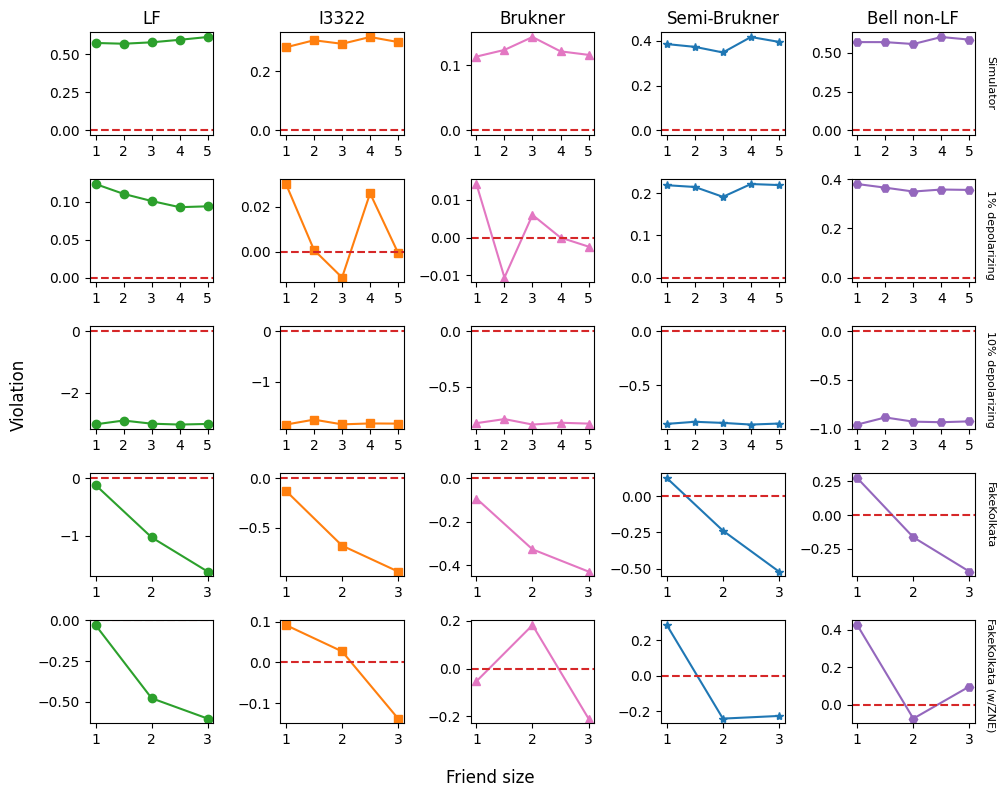

In [16]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10, 8))
friend_sizes = range(1,6)

# Plot: simulator
axs[0, 0].plot(friend_sizes, simulator_values["lf"], marker="o", color="tab:green")
axs[0, 0].set_title("LF")
axs[0, 0].set_xticks(friend_sizes)

axs[0, 1].plot(friend_sizes, simulator_values["I3322"], marker="s", color="tab:orange")
axs[0, 1].set_title("I3322")
axs[0, 1].set_xticks(friend_sizes)

axs[0, 2].plot(friend_sizes, simulator_values["brukner"], marker="^", color="tab:pink")
axs[0, 2].set_title("Brukner")
axs[0, 2].set_xticks(friend_sizes)

axs[0, 3].plot(friend_sizes, simulator_values["semi_brukner"], marker="*", color="tab:blue")
axs[0, 3].set_title("Semi-Brukner")
axs[0, 3].set_xticks(friend_sizes)

axs[0, 4].plot(friend_sizes, simulator_values["bell_non_lf"], marker="H", color="tab:purple")
axs[0, 4].set_title("Bell non-LF")
axs[0, 4].set_xticks(friend_sizes)

# Plot: 1% depolarizing noise
axs[1, 0].plot(friend_sizes, depolarizing_values_1["lf"], marker="o", color="tab:green")
axs[1, 0].set_xticks(friend_sizes)

axs[1, 1].plot(friend_sizes, depolarizing_values_1["I3322"], marker="s", color="tab:orange")
axs[1, 1].set_xticks(friend_sizes)

axs[1, 2].plot(friend_sizes, depolarizing_values_1["brukner"], marker="^", color="tab:pink")
axs[1, 2].set_xticks(friend_sizes)

axs[1, 3].plot(friend_sizes, depolarizing_values_1["semi_brukner"], marker="*", color="tab:blue")
axs[1, 3].set_xticks(friend_sizes)

axs[1, 4].plot(friend_sizes, depolarizing_values_1["bell_non_lf"], marker="H", color="tab:purple")
axs[1, 4].set_xticks(friend_sizes)

# Plot: 10% depolarizing noise
axs[2, 0].plot(friend_sizes, depolarizing_values_10["lf"], marker="o", color="tab:green")
axs[2, 0].set_xticks(friend_sizes)

axs[2, 1].plot(friend_sizes, depolarizing_values_10["I3322"], marker="s", color="tab:orange")
axs[2, 1].set_xticks(friend_sizes)

axs[2, 2].plot(friend_sizes, depolarizing_values_10["brukner"], marker="^", color="tab:pink")
axs[2, 2].set_xticks(friend_sizes)

axs[2, 3].plot(friend_sizes, depolarizing_values_10["semi_brukner"], marker="*", color="tab:blue")
axs[2, 3].set_xticks(friend_sizes)

axs[2, 4].plot(friend_sizes, depolarizing_values_10["bell_non_lf"], marker="H", color="tab:purple")
axs[2, 4].set_xticks(friend_sizes)

friend_sizes = range(1,4)

# Plot: FakeKolkata
axs[3, 0].plot(friend_sizes, fake_kolkata_values["lf"], marker="o", color="tab:green")
axs[3, 0].set_xticks(friend_sizes)

axs[3, 1].plot(friend_sizes, fake_kolkata_values["I3322"], marker="s", color="tab:orange")
axs[3, 1].set_xticks(friend_sizes)

axs[3, 2].plot(friend_sizes, fake_kolkata_values["brukner"], marker="^", color="tab:pink")
axs[3, 2].set_xticks(friend_sizes)

axs[3, 3].plot(friend_sizes, fake_kolkata_values["semi_brukner"], marker="*", color="tab:blue")
axs[3, 3].set_xticks(friend_sizes)

axs[3, 4].plot(friend_sizes, fake_kolkata_values["bell_non_lf"], marker="H", color="tab:purple")
axs[3, 4].set_xticks(friend_sizes)

# Plot: FakeKolkata (with ZNE)
axs[4, 0].plot(friend_sizes, fake_kolkata_values_with_zne["lf"], marker="o", color="tab:green")
axs[4, 0].set_xticks(friend_sizes)

axs[4, 1].plot(friend_sizes, fake_kolkata_values_with_zne["I3322"], marker="s", color="tab:orange")
axs[4, 1].set_xticks(friend_sizes)

axs[4, 2].plot(friend_sizes, fake_kolkata_values_with_zne["brukner"], marker="^", color="tab:pink")
axs[4, 2].set_xticks(friend_sizes)

axs[4, 3].plot(friend_sizes, fake_kolkata_values_with_zne["semi_brukner"], marker="*", color="tab:blue")
axs[4, 3].set_xticks(friend_sizes)

axs[4, 4].plot(friend_sizes, fake_kolkata_values_with_zne["bell_non_lf"], marker="H", color="tab:purple")
axs[4, 4].set_xticks(friend_sizes)


# Adding a red dotted line at y = 0 for each subplot for violation threshold.
for ax in axs.flat:
    ax.axhline(y=0, color="tab:red", linestyle="--")

# Set row labels on the right side
fig.text(1, 0.89, "Simulator", ha="center", va="center", rotation=-90, fontsize=8)
fig.text(1, 0.7, "1% depolarizing", ha="center", va="center", rotation=-90, fontsize=8)
fig.text(1, 0.52, "10% depolarizing", ha="center", va="center", rotation=-90, fontsize=8)
fig.text(1, 0.35, "FakeKolkata", ha="center", va="center", rotation=-90, fontsize=8)
fig.text(1, 0.15, "FakeKolkata (w/ZNE)", ha="center", va="center", rotation=-90, fontsize=8)


fig.supxlabel("Friend size")
fig.supylabel("Violation")

plt.tight_layout()

plt.savefig("simulator_violations.pdf", bbox_inches="tight")
plt.show()